In [1]:
import sys
sys.path.insert(0, "../")

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import flax.linen as nn
from matplotlib import pyplot as plt
import module.util as util

## Score Matching
### The Score Function
Score Matchinig is an integral part of diffusion modelling. In order to represent a probability distribution $p(x)$ for $x \in \Chi$ one can compute its score-function $s$:
$$
s(x) = \nabla \log p(x)
$$
On the other hand, if $s$ satisfies integrability conditions, it unikely characterises the probability distribution $p(x)$, as the integration constant is found via requiring that $p(x)$ is normalised.

### Fitting the Score Function
If one is presented a distribution of data, which we would like to model, it often comes represented by samples $x_i \in D$. Score-Matching tries to obtain the underlying distribution implicitly, by learning the score-function $s$. To do this, we minimise the $L^2$ norm of $s(x) - \nabla \log p(x)$ on the measure-space $(\Chi, \mathcal{B}(\Chi), p\, d\mu)$. Written out, this is:
$$
L[s] = \int_\Chi || s(x) - \nabla \log p(x) ||^2  p(x) d\mu
$$
### Numerics
As the loss-functional $L$ involes (i) and integral over $\Chi$ and (ii) inacessible gradients of $p$, we will make use of partial integration and sampling:
$$
\begin{align}
\min_s L[s] &= \min_s \int_\Chi || s(x) - \nabla \log p(x) ||^2  p(x) d\mu \\
 &=  \min_s \int_\Chi \left[|| s(x) || ^2  - 2 s(x) \cdot \nabla \log p(x)\right]  p(x) d\mu \\
 &= \min_s \int_\Chi p(x) d\mu \left[ ||s(x)||^2 +2 tr(J s(x)) \right] \\
 &\approx \frac{1}{N}\sum_{x_i \sim p(x)}^N ||s(x_i)||^2 +2 tr(J s(x_i))
\end{align}
$$

## Example
In the following we will try to match the score function of a simple example distribution.
### Toy Distribution

In [683]:
key = jax.random.PRNGKey(0)

In [763]:
space_dim = 1

def get_samples(key, N = 1000):
    swap = jax.random.choice(key, jnp.array([-1.,1.]), (N,))
    key, _ = jax.random.split(key)
    x1 = jax.random.normal(key, (N,))*0.2 + swap*0.5

    return jnp.expand_dims(x1, axis = -1)


def calc_log_p(x):
    a = stats.norm.pdf(x, loc = -0.5, scale = 0.2)
    b = stats.norm.pdf(x, loc = 0.5, scale = 0.2)
    return jnp.log(0.5*(a+b))

def calc_score(x):
    score = jax.jvp(calc_log_p, (x,), (jnp.ones_like(x),))[1]
    return score

Text(0.5, 1.0, 'score function and log density')

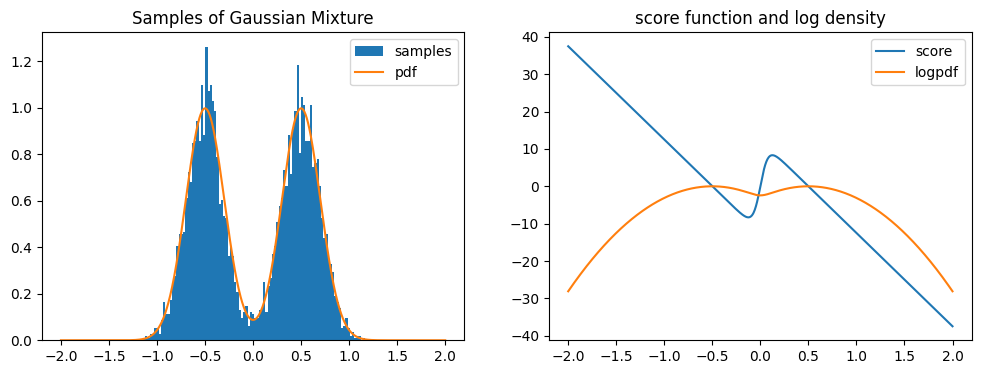

In [764]:
f, axs = plt.subplots(1, 2, figsize = (12,4))

key, _ = jax.random.split(key)
samples = get_samples(key, 5000)
xs = jnp.linspace(-2, 2, num = 1000)
score = calc_score(xs)

axs[0].hist(samples, bins = 100, density=True, label = "samples")
axs[0].plot(xs, jnp.exp(calc_log_p(xs)), label = "pdf")
axs[0].legend()
axs[0].set_title("Samples of Gaussian Mixture")

axs[1].plot(xs, score, label = "score")
axs[1].plot(xs, calc_log_p(xs), label = "logpdf")
axs[1].legend()
axs[1].set_title("score function and log density")

### Define Score Model

In [954]:
act = lambda x: jnp.log(jnp.cosh(x))

class ScoreModel(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(32, bias_init=nn.initializers.normal())(x)
    x = act(x)
    x = nn.Dense(16, bias_init=nn.initializers.normal())(x)
    x = act(x)
    x = nn.Dense(1, bias_init=nn.initializers.normal())(x)
    return x

### Optimisation

In [975]:
model = ScoreModel()
param = model.init(key, jnp.empty((space_dim,)))

In [976]:
@jax.jit
def calc_loss(param, samples):
    N = samples.shape[0]
    # a = 1/N*jnp.sum(model.apply(param, samples)**2)
    # b = 2/N*jnp.sum(w*jax.jvp(model.apply, (param, samples), (util.t_zeros_like(param), w))[0])
    # return a + b

    eval = model.apply(param, samples)
    score = calc_score(samples)

    a = eval ** 2
    b = score ** 2
    c = 2*jax.jvp(model.apply, (param, samples), (util.t_zeros_like(param), jnp.ones_like(samples)))[1]
    # c = -2*eval*jax.jvp(lambda samples: jnp.exp(calc_log_p(samples)), (samples,), (jnp.ones_like(samples),))[1]*jnp.exp(-calc_log_p(samples))
    # c = -2*eval*score

    return jnp.mean(a+b+c)

@jax.jit
def grad_loss(param, samples):
    l = lambda param: calc_loss(param, samples)
    grad = jax.vjp(l, param)[1](jnp.array(1.))
    return grad[0]

In [977]:
losses = []

In [980]:
N = 5000
lr = 0.001
for i in range(900):
    key, _ = jax.random.split(key)
    samples = get_samples(key, N)
    key, _ = jax.random.split(key)
    w = jax.random.normal(key, (N, space_dim))

    loss = calc_loss(param, samples)
    losses.append(loss)

    grad = grad_loss(param, samples)

    param = util.t_sum(param, util.s_mul(-lr, grad))

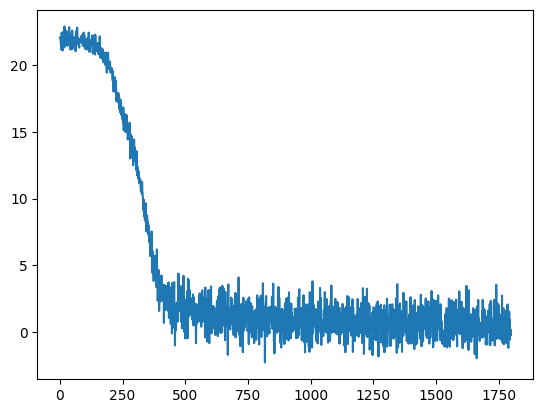

In [983]:
plt.plot(losses)

Text(0.5, 1.0, 'score function and log density')

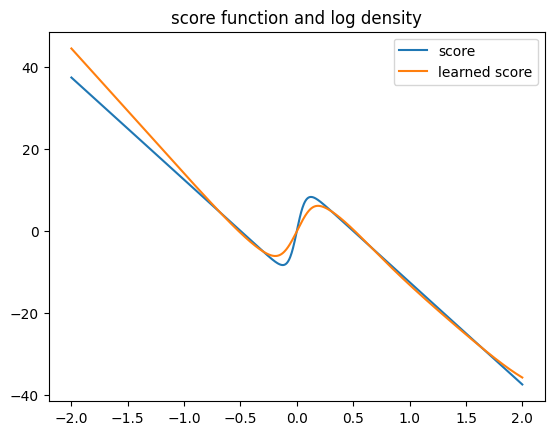

In [984]:
xs = jnp.linspace(-2, 2, num = 1000)
score = jax.jvp(calc_log_p, (xs,), (jnp.ones_like(xs),))[1]
score_approx = model.apply(param, jnp.expand_dims(xs, axis = -1))

plt.plot(xs, score, label = "score")
plt.plot(xs, score_approx, label = "learned score")
plt.legend()
plt.title("score function and log density")

## Sample using the Score-Function
After obtaining the score function, multiple methods are available for generating samples of the underlying distribution. Here, we just use a simple Langevin dynamics which converges to the Boltzmann-distribution:
$$
dx = \nabla \log p\,dt + \sqrt{2}\,dW
$$
Euler-Marujana discretising this leads:
$$
x_{t+\epsilon} = x_{\epsilon} + \epsilon \nabla \log p + \sqrt{2\epsilon}\,\xi_t
$$
where $\epsilon$ is the integration time-step and $\xi_t§ are independent standard normal gaussians.

In [989]:
N_samples = 5000

x = jax.random.normal(key, (N_samples, space_dim))*0.5
epsilon = 0.01

In [990]:
for i in range(50):
    key, _ = jax.random.split(key)
    dx = model.apply(param, x) * epsilon + jnp.sqrt(epsilon)*jax.random.normal(key, (N_samples, space_dim))
    x = x + dx

Text(0.5, 1.0, 'score function and log density')

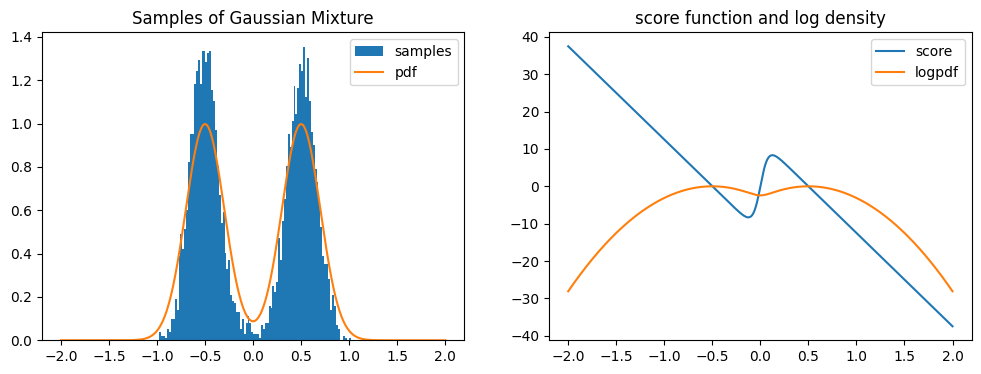

In [991]:
f, axs = plt.subplots(1, 2, figsize = (12,4))

key, _ = jax.random.split(key)
# samples = get_samples(key, 5000)
xs = jnp.linspace(-2, 2, num = 1000)
score = calc_score(xs)

axs[0].hist(x, bins = 100, density=True, label = "samples")
axs[0].plot(xs, jnp.exp(calc_log_p(xs)), label = "pdf")
axs[0].legend()
axs[0].set_title("Samples of Gaussian Mixture")

axs[1].plot(xs, score, label = "score")
axs[1].plot(xs, calc_log_p(xs), label = "logpdf")
axs[1].legend()
axs[1].set_title("score function and log density")